# Extract drug data from DrugCentral

Purpose of this notebook is to extract and format drug data for subsequent model annotation.

## DrugCentral
To utilize this notebook: 


Avram S, Wilson TB, Curpan R, Halip L, Borota A, Bora A, Bologa CG, Holmes J, Knockel J, Yang JJ, Oprea TI. DrugCentral 2023 extends human clinical data and integrates veterinary drugs. Nucleic Acids Res. 2023 Jan 6;51(D1):D1276-D1287. doi: 10.1093/nar/gkac1085. PMID: 36484092; PMCID: PMC9825566.

## Setup
### Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from rbc_gem_utils import (
    ROOT_PATH,
    INTERIM_PATH,
    DATABASE_PATH,
    ANNOTATION_PATH,
    GEM_NAME,
    compare_tables,
    visualize_comparison,
    get_annotation_df,
    read_rbc_model,
    show_versions,
    split_string,
    build_string,
    explode_column,
)

DRUGCENTRAL_DB_TAG = "DrugCentral"
DRUGCENTRAL_PATH = "/DrugCentral"

## Load RBC-GEM model

In [2]:
model = read_rbc_model(filetype="xml")
model

Name,RBC_GEM
Memory address,108a2e690
Number of metabolites,1955
Number of reactions,2777
Number of genes,649
Number of groups,74
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space"


In [3]:
annotation_type = "genes"
df_model_mappings = get_annotation_df(
    getattr(model, annotation_type),
    ["uniprot", "drugbank", "drugcentral", "hgnc.symbol"],
).rename({"id": annotation_type}, axis=1)

for col in df_model_mappings.columns:
    df_model_mappings[col] = df_model_mappings[col].apply(split_string)
    df_model_mappings = df_model_mappings.explode(col)
df_model_mappings = df_model_mappings.drop_duplicates()
print(df_model_mappings.nunique(dropna=True))
df_model_mappings

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.
genes           649
uniprot         649
drugbank       2041
drugcentral     633
hgnc.symbol     650
dtype: int64


,genes,uniprot,drugbank,drugcentral,hgnc.symbol
0,RPE,Q96AT9,DB00153,NaN,RPE
1,RPIA,P49247,DB01756,NaN,RPIA
2,SORD,Q00796,DB04478,1021,SORD
2,SORD,Q00796,DB04478,3514,SORD
2,SORD,Q00796,DB00157,1021,SORD
...,...,...,...,...,...
647,SLC22A4,Q9H015,DB13946,NaN,SLC22A4
647,SLC22A4,Q9H015,DB08837,NaN,SLC22A4
647,SLC22A4,Q9H015,DB01409,NaN,SLC22A4
647,SLC22A4,Q9H015,DB00661,NaN,SLC22A4


## Set notebook options

In [4]:
database_dirpath = f"{ROOT_PATH}{DATABASE_PATH}"
annotation_dirpath = f"{ROOT_PATH}{ANNOTATION_PATH}"
# Compare to/Overwrite previous files
compare = True
display_nunique = True
overwrite = True
mapping_key = "uniprot"
df_model_mappings.loc[:, [annotation_type, mapping_key]].drop_duplicates()

,genes,uniprot
0,RPE,Q96AT9
1,RPIA,P49247
2,SORD,Q00796
3,AKR7A2,O43488
4,SRM,P19623
...,...,...
644,SLC25A31,Q9H0C2
645,ENTPD1,P49961
646,SLC22A7,Q9Y694
647,SLC22A4,Q9H015


## Parse DrugCentral information into DataFrame

In [5]:
df_drugcentral = pd.read_csv(
    f"{database_dirpath}{DRUGCENTRAL_PATH}/drug.target.interaction.txt",
    sep="\t",
    dtype=str,
)
# Filter out non-human entries
df_drugcentral = df_drugcentral[
    df_drugcentral["ORGANISM"].str.find("Homo sapiens") != -1
]
df_drugcentral

,DRUG_NAME,STRUCT_ID,TARGET_NAME,TARGET_CLASS,ACCESSION,GENE,SWISSPROT,ACT_VALUE,ACT_UNIT,ACT_TYPE,ACT_COMMENT,ACT_SOURCE,RELATION,MOA,MOA_SOURCE,ACT_SOURCE_URL,MOA_SOURCE_URL,ACTION_TYPE,TDL,ORGANISM
0,levobupivacaine,4,Potassium voltage-gated channel subfamily H me...,Ion channel,Q12809,KCNH2,KCNH2_HUMAN,4.89,NaN,IC50,Inhibition of wild-type human ERG channel expr...,CHEMBL,=,NaN,NaN,NaN,NaN,NaN,Tclin,Homo sapiens
1,levobupivacaine,4,Sodium channel protein type 1 subunit alpha,Ion channel,P35498,SCN1A,SCN1A_HUMAN,5.79,NaN,IC50,NaN,WOMBAT-PK,=,NaN,NaN,NaN,NaN,NaN,Tclin,Homo sapiens
2,levobupivacaine,4,Sodium channel protein type 4 subunit alpha,Ion channel,P35499,SCN4A,SCN4A_HUMAN,NaN,NaN,NaN,NaN,WOMBAT-PK,NaN,1,CHEMBL,NaN,https://www.ebi.ac.uk/chembl/compound/inspect/...,BLOCKER,Tclin,Homo sapiens
3,levobupivacaine,4,Prostaglandin E2 receptor EP1 subtype,GPCR,P34995,PTGER1,PE2R1_HUMAN,NaN,NaN,NaN,NaN,WOMBAT-PK,NaN,NaN,NaN,NaN,NaN,NaN,Tclin,Homo sapiens
4,levobupivacaine,4,Cytochrome P450 2D6,Enzyme,P10635,CYP2D6,CP2D6_HUMAN,6.707,NaN,IC50,"DRUGMATRIX: CYP450, 2D6 enzyme inhibition (sub...",DRUG MATRIX,=,NaN,NaN,NaN,NaN,NaN,Tclin,Homo sapiens
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19370,infigratinib,5459,Fibroblast growth factor receptor 1,Kinase,P11362,FGFR1,FGFR1_HUMAN,8.99,NaN,NaN,Mechanism of Action,DRUG LABEL,=,1,DRUG LABEL,https://www.accessdata.fda.gov/drugsatfda_docs...,https://www.accessdata.fda.gov/drugsatfda_docs...,INHIBITOR,Tclin,Homo sapiens
19371,samidorphan,5460,Mu-type opioid receptor,GPCR,P35372,OPRM1,OPRM_HUMAN,10.28,NaN,Ki,Possible target for the mechanism of action of...,DRUG LABEL,=,NaN,NaN,https://www.accessdata.fda.gov/drugsatfda_docs...,NaN,ANTAGONIST,Tclin,Homo sapiens
19372,samidorphan,5460,Kappa-type opioid receptor,GPCR,P41145,OPRK1,OPRK_HUMAN,9.64,NaN,Ki,NaN,DRUG LABEL,=,NaN,NaN,https://www.accessdata.fda.gov/drugsatfda_docs...,NaN,PARTIAL AGONIST,Tclin,Homo sapiens
19373,samidorphan,5460,Delta-type opioid receptor,GPCR,P41143,OPRD1,OPRD_HUMAN,8.59,NaN,Ki,NaN,DRUG LABEL,=,NaN,NaN,https://www.accessdata.fda.gov/drugsatfda_docs...,NaN,PARTIAL AGONIST,Tclin,Homo sapiens


In [6]:
rename_mapping = {col: col.lower() for col in df_drugcentral.columns}
rename_mapping.update(
    {
        "ACCESSION": "uniprot",
        "GENE": "hgnc.symbol",
        "STRUCT_ID": "drugcentral",
        "drug_name": "name",
    }
)
df_model_drugcentral = pd.merge(
    df_model_mappings.loc[:, [annotation_type, mapping_key]],
    df_drugcentral.rename(rename_mapping, axis=1),
    left_on=mapping_key,
    right_on=mapping_key,
    how="left",
)

df_model_drugcentral = df_model_drugcentral[df_model_drugcentral["drugcentral"].notna()]
# df_model_drugcentral = df_model_drugcentral.groupby(annotation_type, as_index=False).agg(lambda x:  build_string(list(x.dropna().unique())))
df_model_drugcentral = df_model_drugcentral.loc[
    :,
    [
        "genes",
        "uniprot",
        "hgnc.symbol",
        "drugcentral",
        "drug_name",
        "target_class",
        "action_type",
    ],
]
df_model_drugcentral = df_model_drugcentral.drop_duplicates().reset_index(drop=True)

if display_nunique:
    for col in df_model_drugcentral.columns:
        df = (
            df_model_drugcentral[col]
            .apply(lambda x: split_string(x))
            .explode(col)
            .drop_duplicates()
        )

        print(f"{df.name}: {df.nunique()}")

df_model_drugcentral = df_model_drugcentral.reset_index(drop=True)
if overwrite:
    df_model_drugcentral.to_csv(
        f"{database_dirpath}{DRUGCENTRAL_PATH}/{DRUGCENTRAL_DB_TAG}_{GEM_NAME}.tsv",
        sep="\t",
    )
else:
    df_model_drugcentral.to_csv(
        f"{ROOT_PATH}{INTERIM_PATH}/{DRUGCENTRAL_DB_TAG}_{GEM_NAME}.tsv", sep="\t"
    )
df_model_drugcentral

genes: 190
uniprot: 190
hgnc.symbol: 190
drugcentral: 640
drug_name: 640
target_class: 9
action_type: 10


,genes,uniprot,hgnc.symbol,drugcentral,drug_name,target_class,action_type
0,SORD,Q00796,SORD,1021,epalrestat,Enzyme,NaN
1,SORD,Q00796,SORD,3514,quercetin,Enzyme,NaN
2,THTPA,Q9BU02,THTPA,2832,thiamine,Enzyme,NaN
3,TKT,P29401,TKT,2832,thiamine,Enzyme,NaN
4,TPK1,Q9H3S4,TPK1,2832,thiamine,Kinase,NaN
...,...,...,...,...,...,...,...
1292,PRKD1,Q15139,PRKD1,5252,neratinib,Kinase,NaN
1293,PRKG1,Q13976,PRKG1,4903,nintedanib,Kinase,NaN
1294,PRKG1,Q13976,PRKG1,5231,midostaurin,Kinase,NaN
1295,PRKG1,Q13976,PRKG1,5347,fedratinib,Kinase,NaN


genes: 190
uniprot: 190
hgnc.symbol: 190
drugcentral: 640


,genes,uniprot,hgnc.symbol,drugcentral
0,ABCA1,O95477,ABCA1,2269
1,ABCB1,P08183,ABCB1,82;114;119;176;191;219;242;249;254;271;276;419...
2,ABCC1,P33527,ABCC1,219;318;726;760;786;960;1112;1115;1414;1423;14...
3,ABCC10,Q5T3U5,ABCC10,219;939;2044;2823;2825
4,ABCC4,O15439,ABCC4,269;1482;1708;1751;2632;2707
...,...,...,...,...
185,TRPV2,Q9Y5S1,TRPV2,5288
186,TXNRD1,Q16881,TXNRD1,244;1763;4122;4349;4706
187,UMPS,P11172,UMPS,2002
188,VCP,P55072,VCP,719;1364;2817


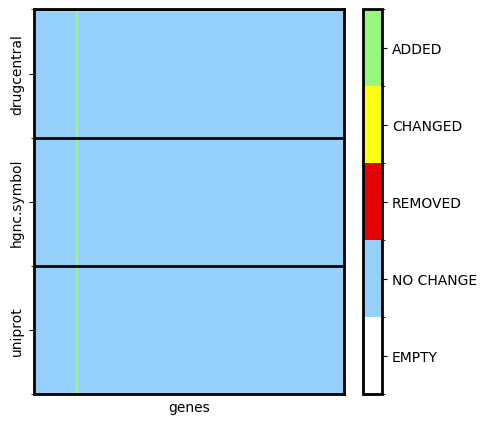

In [7]:
rename_mapping = {
    "ACCESSION": "uniprot",
    "GENE": "hgnc.symbol",
    "STRUCT_ID": "drugcentral",
}

df_annotations = pd.merge(
    df_model_mappings.loc[:, [annotation_type, mapping_key]],
    df_drugcentral.loc[:, list(rename_mapping)].rename(rename_mapping, axis=1),
    left_on=mapping_key,
    right_on=mapping_key,
    how="left",
)
df_annotations = df_annotations.dropna().drop_duplicates()
df_annotations = df_annotations.groupby(annotation_type).agg(
    lambda x: build_string(list(x.unique()))
)
df_annotations = df_annotations.reset_index(drop=False)
df_annotations = df_annotations.replace("", float("nan"))
df_annotations = df_annotations.dropna().drop_duplicates()

if compare:
    try:
        df_previous = pd.read_csv(
            f"{annotation_dirpath}/{annotation_type}_{DRUGCENTRAL_DB_TAG}.tsv",
            sep="\t",
            index_col=0,
            dtype=str,
        )
    except FileNotFoundError:
        df_previous = pd.DataFrame([], columns=[annotation_type], dtype=str)
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    df_comparision = compare_tables(
        df_previous.set_index(annotation_type),
        df_annotations.set_index(annotation_type),
    )
    ax = visualize_comparison(df_comparision)

if display_nunique:
    for col in df_annotations.columns:
        df = (
            df_annotations[col]
            .apply(lambda x: split_string(x))
            .explode(col)
            .drop_duplicates()
        )

        print(f"{df.name}: {df.nunique()}")

if overwrite:
    df_annotations.to_csv(
        f"{annotation_dirpath}/{annotation_type}_{DRUGCENTRAL_DB_TAG}.tsv", sep="\t"
    )
else:
    df_annotations.to_csv(
        f"{ROOT_PATH}{INTERIM_PATH}/{annotation_type}_{DRUGCENTRAL_DB_TAG}.tsv",
        sep="\t",
    )
df_annotations